In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [17, 6]
from IPython.display import Audio

In [2]:
import numpy as np
import torch
from scipy.signal import find_peaks
from librosa.display import waveshow
import librosa

In [3]:
from rt_ddsp.synths import FilteredNoise
from rt_ddsp import core

## Make some changes

In [4]:
n_samples = 32000
sample_rate = 16000
n_bands = 100

In [5]:
noise = FilteredNoise(n_samples, sample_rate)

In [42]:
filter_bank_magnitudes = torch.zeros((3, 500, n_bands), dtype=torch.float32)
filter_bank_magnitudes[:, :, 0] = 4.0
filter_bank_magnitudes[:, :, 25] = 10.0
filter_bank_magnitudes[:, :, 50] = 5.0
filter_bank_magnitudes[:, :, 70] = 9.0
signal = noise(filter_bank_magnitudes)
np_signal = signal[0].numpy()
np_fft = np.abs(np.fft.rfft(np_signal))

In [43]:
Audio(np_signal, rate=sample_rate, normalize=False)

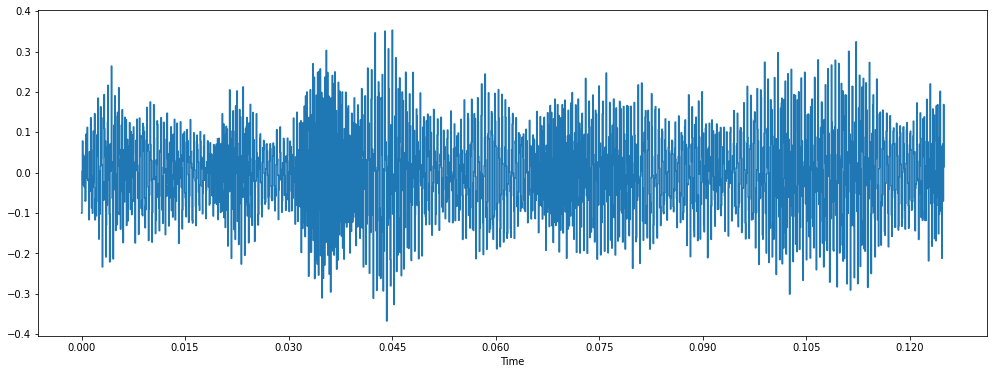

In [44]:
waveshow(np_signal[:2000], sr=sample_rate)
plt.show()

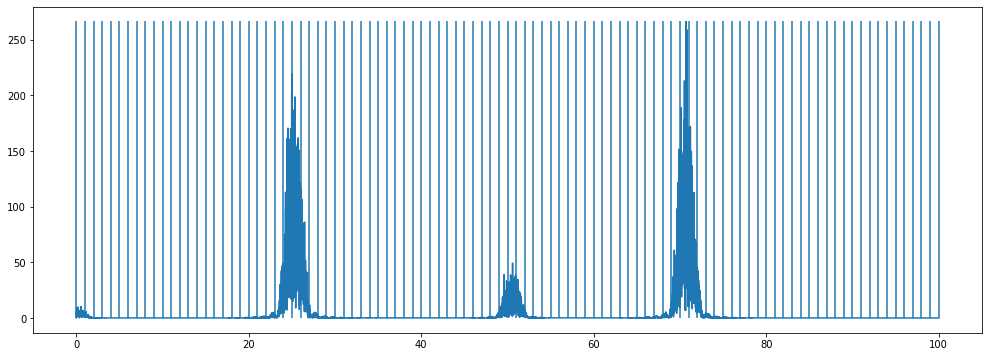

In [45]:
plt.plot(np.linspace(0, 100, len(np_fft)), np_fft)
plt.vlines(x=[i * (100 / n_bands) for i in range(n_bands + 1)], ymin=0, ymax=np_fft.max())
plt.show()

In [46]:
bands = np.array([np.mean(np_fft[i * (len(np_fft) // n_bands):(i + 1) * (len(np_fft) // n_bands)]) for i in range(n_bands)])
bands /= n_samples / 2
bands = np.log(bands+1)

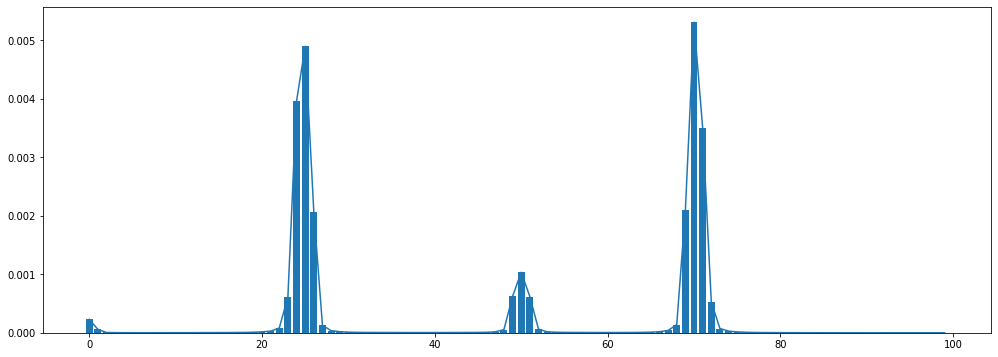

In [47]:
plt.bar(range(100), bands)
plt.plot(bands)
plt.show()

## Notes

We have got the energy bands. Scaling is a bit weird. I guess thats because I don't know how filters work. To be continued...